## Modeling 

Now that our EDA is completed, it's time to select the features that we want to use in our model. We know that we have a very imbalanced class ratio, approximately 95-5 split. We have a choice of of applying balancing transformers like SMOTE, although it has been suggested that SMOTE is more relevant for more severe class balances. We will run models with and without resampling to compare the results.

The methodology is as follows:

1. Apply StandardScaler to our data.
    - we fit on the train set and transform the train and val sets.
    - this step is necessary due to us needing to perform resampling techniques on our data
2. Run a model without resampling to compare results against a model with resampling
    - we will use SMOTE for this
3. If modeling with resampling proves better, continue modeling this way
    - apply SMOTE and ADASYN to compare effects.
4. Choose best model and finetune further.

Finally we will end with an evaluation of our model, as well as some Cost Benefit Analysis to discuss the monetary and public health costs of West Nile Virus, and finally some recommendations on dealing with this issue.

In [7]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline as skpipe

import xgboost as xgb
import lightgbm as lgbm

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as imbpipe

pd.options.display.html.use_mathjax = False
%matplotlib inline

In [2]:
# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Load data

In [3]:
# load data in
X_train = pd.read_csv('../predict_data/X_train.csv').drop(columns=['Trap','Sunrise','Sunset']) # drop because we won't use these
X_val = pd.read_csv('../predict_data/X_val.csv').drop(columns=['Trap','Sunrise','Sunset'])
y_train = pd.read_csv('../predict_data/y_train.csv')
y_val = pd.read_csv('../predict_data/y_val.csv')

In [48]:
# have a look at the features we are using
X_train.columns

Index(['Latitude', 'Longitude', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Heat/Cool', 'SunHours', 'isRainy', 'Humidity', 'Year',
       'Month', 'Week', 'DewPoint_Roll22Lag1', 'WetBulb_Roll16Lag7',
       'AvgSpeed_Roll22Lag5', 'Humidity_Roll16Lag1', 'isRainy_Roll6Lag21',
       'PrecipTotal_Roll1Lag5', 'ResultSpeed_Roll23Lag5',
       'Heat/Cool_Roll12Lag12', 'Tavg_Roll12Lag12', 'Precip_X_DewPointRL',
       'Precip_X_WetBulbRL', 'Precip_X_TavgRL', 'Precip_X_ResultDir',
       'Precip_X_Latitude', 'Precip_X_Longitude', 'Species_1.0', 'Species_2.0',
       'Species_3.0'],
      dtype='object')

### Scaling our data
As we are intending to try out using SMOTE/ADASYN later, we first have to scale our data.

In [4]:
# create a function that scales ONLY our continuous variables. we want to leave our binary variables alone.

def custom_scaler(df, cat_cols, fit=False):

    # separate categorical and continuous variables
    df_cat = df[cat_cols]
    df_cont = df.drop(columns = df_cat.columns)

    # create our scaler
    if fit: # <------------ this is to be set to True the FIRST time we run this function on our train set
        global ss
        ss = StandardScaler()
        df_cont_scaled = ss.fit_transform(df_cont)  # <---- fit our Scaler on our training set
    else: # <----- after our first run, our Scaler is already fit, so let fit==False and we will go straight to transform.
        df_cont_scaled = ss.transform(df_cont) 

    # put this scaled data back into a dataframe
    df_cont_scaled_df = pd.DataFrame(df_cont_scaled, columns = df_cont.columns)

    # concat this scaled table with our cat variables and target variable and save it back as our X_scaled.
    X_scaled = pd.concat([df_cont_scaled_df, df_cat], axis=1)
    return X_scaled

In [5]:
# scale our data and change our target variables to a 1D-array
cat_cols = ['Species_1.0', 'Species_2.0', 'Species_3.0', 'isRainy']
X_train_sc = custom_scaler(X_train, cat_cols, fit=True)
X_val_sc = custom_scaler(X_val, cat_cols, fit=False)
y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()

In [6]:
# take a look at the features we have
X_train_sc.columns

Index(['Latitude', 'Longitude', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Heat/Cool', 'SunHours', 'Humidity', 'Year', 'Month',
       'Week', 'DewPoint_Roll22Lag1', 'WetBulb_Roll16Lag7',
       'AvgSpeed_Roll22Lag5', 'Humidity_Roll16Lag1', 'isRainy_Roll6Lag21',
       'PrecipTotal_Roll1Lag5', 'ResultSpeed_Roll23Lag5',
       'Heat/Cool_Roll12Lag12', 'Tavg_Roll12Lag12', 'Precip_X_DewPointRL',
       'Precip_X_WetBulbRL', 'Precip_X_TavgRL', 'Precip_X_ResultDir',
       'Precip_X_Latitude', 'Precip_X_Longitude', 'Species_1.0', 'Species_2.0',
       'Species_3.0', 'isRainy'],
      dtype='object')

### Create iterative modeling functions

These functions below will help us to quickly instantiate and score our models, allowing us to find the best performing one.

In [8]:
resamplers = {'smote': SMOTE(random_state=42),
              'adasyn': ADASYN(random_state=42)}

models = {'lr': LogisticRegression(max_iter=5000, random_state=101),
          'rf': RandomForestClassifier(random_state=101),
          'et': ExtraTreesClassifier(random_state=101),
          'ada': AdaBoostClassifier(DecisionTreeClassifier(), random_state=101),
          'gb': GradientBoostingClassifier(random_state=101),
          'xgb': xgb.XGBClassifier(random_state=101),
          'lgbm': lgbm.LGBMClassifier(random_state=101),
          'sgd':SGDClassifier(random_state=101)
         }

def gscv_creator(resampler, model, pipe_params, n_jobs=-1, resample=False, pca=False):
    """
    helps me instantiate my models quickly. 
    ensure that your parameters for gridsearching are prefixed correctly according to the dunder__ convention 
    leave n_jobs as -1 unless you have good reason for making it slower and more painful than necessary.
    """
    if resample:
        pipe = imbpipe([
            (resampler, resamplers[resampler]),
            (model, models[model]),
        ])
    elif resample and pca:
        pipe = imbpipe([
            (resampler, resamplers[resampler]),
            ('pca', PCA()),
            (model, models[model]),
        ])
    else:
        pipe = skpipe([
            (model, models[model]),
        ])
    
    gs = GridSearchCV(pipe,
                      pipe_params,
                      cv=5,
                      scoring='roc_auc',
                      verbose=1,
                      n_jobs=n_jobs) # force maximum number of concurrent workers

    return gs

In [9]:
# this function prints a bunch of summary stats about our GridSearchCV object. 
# it requires that our GridSearchCV object has been fit on the training set already.

def gscv_result_printer(gs, X=None, y=None):
    """
    feed in a GridSearchCV that is already fit on X_train, y_train.
    prints out a bunch of stuff to compare
    """
    print("Best CV score: {}".format(gs.best_score_))
    print("Best params: {}".format(gs.best_params_))
    print('----------')
    predictions = gs.predict(X_train_sc)
    try:
        pred_probas = gs.predict_proba(X_train_sc)[:,1]
        print("Training ROC AUC: {}".format(roc_auc_score(y_train, pred_probas)))
    except:
        print('Model has no predict_proba function')
    print("Training recall: {}".format(recall_score(y_train, predictions)))
    print("Training accuracy: {}".format(accuracy_score(y_train, predictions)))
    print('----------')
    # pass in X and Y arguments if you would like to score the gs object on something else, like the X_val set.
    if X is not None:
        predictions = gs.predict(X)
        try:
            pred_probas = gs.predict_proba(X)[:,1]
            print("Validation ROC AUC: {}".format(roc_auc_score(y, pred_probas)))
        except:
            print('Model has no predict_proba function')            
        print("Validation recall: {}".format(recall_score(y, predictions)))
        print("Validation accuracy: {}".format(accuracy_score(y, predictions)))
        tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
        print(pd.DataFrame({'WNV present': [tp,fn],
                            'WNV not present': [fp,tn]},
                           index=['Predicted WNV', 'No predicted WNV']))

        

### Model factory

When considering the performance of our model we will be looking at 2 main metrics. Of primary importance is the ROC-AUC score, which is a measure of how well our model can discriminate between 2 classes. Of secondary importance is recall, or sensitivity. This is important to us because as West Nile Virus is an issue of public health, we want to especially minimize our **False Negatives**. Falsely predicting the absence of the virus could lead to unhindered propagation of the virus within a particular area. In contrast, false positives might unduly alarm residents, but does not pose any risk to their health. Additionally, we will also monitor accuracy, although this is of tertiary importance. We are curious about this metric simply because we want to see how many false positives we get in the end, as this would affect the cost of spraying undertaken by the city.

Due to our imbalanced dataset, we should apply balancing techniques like SMOTE or ADASYN. To convince ourselves of the effect of these techniques, we'll try running a model *without* over-sampling our minority class and observe our results.

#### No SMOTE


In [9]:
# LogReg with no smote
pipe_params = {
    'lr__C':[1.0,0.5],
    'lr__penalty':['elasticnet'],
    'lr__l1_ratio': [0,0.5,1],
    'lr__solver': ['saga']
}

lr_cv = gscv_creator('smote','lr', pipe_params, resample=False)
lr_cv.fit(X_train_sc, y_train)
gscv_result_printer(lr_cv, X_val_sc, y_val)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV score: 0.8151280498025413
Best params: {'lr__C': 1.0, 'lr__l1_ratio': 1, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}
----------
Training ROC AUC: 0.8339191596221511
Training recall: 0.0
Training accuracy: 0.9461077844311377
----------
Validation ROC AUC: 0.8367121683110329
Validation recall: 0.0
Validation accuracy: 0.9460135859849839
                  WNV present  WNV not present
Predicted WNV               0                0
No predicted WNV          151             2646


As we can see, without applying SMOTE to our data, our model simply chooses to predict *every* observation as WNV not present, even though it has decent ROC-AUC. Obviously this is not what we want, and is in fact dangerous to public health. According to our secondary metric, this model is not acceptable. 

### With SMOTE

#### Linear models

In [55]:
# LogReg with SMOTE
pipe_params = {
    'smote__k_neighbors':[2,3,5],
    'lr__C':[1.0,0.5],
    'lr__penalty':['elasticnet'],
    'lr__l1_ratio': [0,0.5,1],
    'lr__solver': ['saga']
}

lr_smote_cv = gscv_creator('smote','lr', pipe_params, resample=True)
lr_smote_cv.fit(X_train_sc, y_train)
gscv_result_printer(lr_smote_cv, X_val_sc, y_val)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best CV score: 0.7968943654541716
Best params: {'lr__C': 1.0, 'lr__l1_ratio': 1, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'smote__k_neighbors': 2}
----------
Training ROC AUC: 0.8195569863587033
Training recall: 0.7450980392156863
Training accuracy: 0.7412821415991546
----------
Validation ROC AUC: 0.8187743088405339
Validation recall: 0.7549668874172185
Validation accuracy: 0.7479442259563819
                  WNV present  WNV not present
Predicted WNV             114              668
No predicted WNV           37             1978


Here we can clearly see that SMOTE has done wonders to increase our recall, at the cost of a very slightly lower AUROC. We are actually predicting True Positives now! Hence we apply resampling techniques for all our models following this, in order to maximize BOTH ROC-AUC and Recall. Let's try out another model now with SMOTE. 

In [56]:
# SGDClassifier with SMOTE
pipe_params = {
    'smote__k_neighbors':[5],
    'sgd__loss':['log'],
    'sgd__alpha': np.linspace(0.001,0.01,10),
    'sgd__max_iter':[5000]
}
sgd_cv = gscv_creator('smote','sgd', pipe_params, resample=True)
sgd_cv.fit(X_train_sc, y_train)
gscv_result_printer(sgd_cv, X_val_sc, y_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CV score: 0.790497386550136
Best params: {'sgd__alpha': 0.005, 'sgd__loss': 'log', 'sgd__max_iter': 5000, 'smote__k_neighbors': 5}
----------
Training ROC AUC: 0.8097846981930027
Training recall: 0.7222222222222222
Training accuracy: 0.73617470940472
----------
Validation ROC AUC: 0.8183087804658287
Validation recall: 0.7748344370860927
Validation accuracy: 0.752592062924562
                  WNV present  WNV not present
Predicted WNV             117              658
No predicted WNV           34             1988


#### Tree Models

In [57]:
# RF with SMOTE
pipe_params = {
    'smote__k_neighbors':[3,5],
    'rf__n_estimators':[100,200],
    'rf__max_depth':[None,3,5],
    'rf__min_samples_leaf':[2,5]
}

rf_cv = gscv_creator('smote', 'rf', pipe_params, resample=True)
rf_cv.fit(X_train_sc, y_train)
gscv_result_printer(rf_cv, X_val_sc, y_val)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV score: 0.8178864222878689
Best params: {'rf__max_depth': 5, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 100, 'smote__k_neighbors': 5}
----------
Training ROC AUC: 0.8532800188827081
Training recall: 0.8594771241830066
Training accuracy: 0.7007749207467419
----------
Validation ROC AUC: 0.8355546044760804
Validation recall: 0.7947019867549668
Validation accuracy: 0.7018233821952091
                  WNV present  WNV not present
Predicted WNV             120              803
No predicted WNV           31             1843


In [58]:
# ET with SMOTE
pipe_params = {
    'smote__k_neighbors':[2,3,5],
    'et__n_estimators':[100,200],
    'et__max_depth':[None,3,5],
    'et__min_samples_leaf':[2,5]
}

et_smote_cv = gscv_creator('smote','et', pipe_params, resample=True)
et_smote_cv.fit(X_train_sc, y_train)
gscv_result_printer(et_smote_cv, X_val_sc, y_val)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV score: 0.8164048747327414
Best params: {'et__max_depth': 5, 'et__min_samples_leaf': 5, 'et__n_estimators': 100, 'smote__k_neighbors': 3}
----------
Training ROC AUC: 0.8440488444074576
Training recall: 0.8627450980392157
Training accuracy: 0.6921451215216625
----------
Validation ROC AUC: 0.821625044425423
Validation recall: 0.8145695364238411
Validation accuracy: 0.6914551304969611
                  WNV present  WNV not present
Predicted WNV             123              835
No predicted WNV           28             1811


In [101]:
et_ftimp = et_smote_cv.best_estimator_['et'].feature_importances_
et_ft = pd.DataFrame(et_ftimp, columns=['importance'],index=X_train_sc.columns).sort_values(by='importance',ascending=False)
et_ft

,importance
Species_2.0,0.107755
AvgSpeed_Roll22Lag5,0.101119
WetBulb_Roll16Lag7,0.088159
SunHours,0.082926
Tavg_Roll12Lag12,0.079560
Week,0.076609
Precip_X_DewPointRL,0.061970
DewPoint_Roll22Lag1,0.060297
Heat/Cool_Roll12Lag12,0.058458
Humidity_Roll16Lag1,0.038006


#### Boosters

In [59]:
# AdaBoost with SMOTE
pipe_params = {
    'ada__n_estimators':[200,300],
    'ada__base_estimator__max_depth':[1,2],
    'ada__learning_rate':[0.9,0.5]
}

ada_smote_cv = gscv_creator('smote', 'ada', pipe_params, resample=True)
ada_smote_cv.fit(X_train_sc, y_train)
gscv_result_printer(ada_smote_cv, X_val_sc, y_val)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV score: 0.8108489655841931
Best params: {'ada__base_estimator__max_depth': 1, 'ada__learning_rate': 0.5, 'ada__n_estimators': 200}
----------
Training ROC AUC: 0.8534637359535524
Training recall: 0.6928104575163399
Training accuracy: 0.7948221204649525
----------
Validation ROC AUC: 0.8331218432921366
Validation recall: 0.6688741721854304
Validation accuracy: 0.7954951734000715
                  WNV present  WNV not present
Predicted WNV             101              522
No predicted WNV           50             2124


In [60]:
# GBooster with SMOTE
pipe_params = {
    'gb__n_estimators':[200,300],
    'gb__max_depth':[1,2],
    'gb__learning_rate':[0.9,0.5]
}

gb_smote_cv = gscv_creator('smote','gb', pipe_params, resample=True)
gb_smote_cv.fit(X_train_sc, y_train)
gscv_result_printer(gb_smote_cv, X_val_sc, y_val)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV score: 0.8049717716543341
Best params: {'gb__learning_rate': 0.5, 'gb__max_depth': 1, 'gb__n_estimators': 200}
----------
Training ROC AUC: 0.8502450372057485
Training recall: 0.7156862745098039
Training accuracy: 0.7985206058471293
----------
Validation ROC AUC: 0.8309819144729268
Validation recall: 0.6887417218543046
Validation accuracy: 0.8008580622095102
                  WNV present  WNV not present
Predicted WNV             104              510
No predicted WNV           47             2136


In [61]:
#XGB with SMOTE
pipe_params = {
    'smote__k_neighbors':[3,5],
    'xgb__objective':['binary:logistic'],
    'xgb__eval_metric':['auc'],
    'xgb__use_label_encoder':[False],
    'xgb__max_depth':[None, 2, 3],
    'xgb__subsample':[0.5], # suggested by XGBoost documentation to prevent overfitting
    'xgb__learning_rate':[0.9,0.5, 0.1],
    'xgb__n_estimators':[200,300],
}

xgb_smote_cv = gscv_creator('smote','xgb', pipe_params, resample=True)
xgb_smote_cv.fit(X_train_sc, y_train)
gscv_result_printer(xgb_smote_cv, X_val_sc, y_val)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV score: 0.8085177226855482
Best params: {'smote__k_neighbors': 3, 'xgb__eval_metric': 'auc', 'xgb__learning_rate': 0.1, 'xgb__max_depth': 2, 'xgb__n_estimators': 200, 'xgb__objective': 'binary:logistic', 'xgb__subsample': 0.5, 'xgb__use_label_encoder': False}
----------
Training ROC AUC: 0.8741355564315575
Training recall: 0.7745098039215687
Training accuracy: 0.8055653399084185
----------
Validation ROC AUC: 0.845687355148093
Validation recall: 0.7152317880794702
Validation accuracy: 0.7947801215588131
                  WNV present  WNV not present
Predicted WNV             108              531
No predicted WNV           43             2115


In [70]:
xgb_ftimp = xgb_smote_cv.best_estimator_['xgb'].feature_importances_
pd.DataFrame(xgb_ftimp, columns=['importance'],index=X_train_sc.columns).sort_values(by='importance',ascending=False)

,importance
SunHours,0.156951
WetBulb_Roll16Lag7,0.140750
Species_2.0,0.060526
isRainy_Roll6Lag21,0.055668
Month,0.051457
AvgSpeed_Roll22Lag5,0.045872
Humidity_Roll16Lag1,0.043011
Heat/Cool_Roll12Lag12,0.041515
Heat/Cool,0.040670
ResultSpeed,0.034012


In [63]:
# LGBM with SMOTE
pipe_params = {
    'smote__k_neighbors':[5],
    'lgbm__objective':['binary'],
    'lgbm__max_depth':[None, 2, 3],
    'lgbm__subsample':[0.5], 
    'lgbm__learning_rate':[0.3,0.5],
    'lgbm__n_estimators':[100,200],
    'lgbm__reg_alpha':[0,0.5], 
    'lgbm__reg_lambda':[1,0.5], 
    'lgbm__min_child_samples':[10,20],
    'lgbm__num_leaves':[8,16]
}

lgbm_smote_cv = gscv_creator('smote','lgbm', pipe_params, resample=True)
lgbm_smote_cv.fit(X_train_sc, y_train)
gscv_result_printer(lgbm_smote_cv, X_val_sc, y_val)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best CV score: 0.8071881231824578
Best params: {'lgbm__learning_rate': 0.3, 'lgbm__max_depth': 2, 'lgbm__min_child_samples': 20, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 8, 'lgbm__objective': 'binary', 'lgbm__reg_alpha': 0, 'lgbm__reg_lambda': 0.5, 'lgbm__subsample': 0.5, 'smote__k_neighbors': 5}
----------
Training ROC AUC: 0.8742776025773923
Training recall: 0.738562091503268
Training accuracy: 0.8284607256076083
----------
Validation ROC AUC: 0.8404601722955555
Validation recall: 0.6423841059602649
Validation accuracy: 0.8187343582409725
                  WNV present  WNV not present
Predicted WNV              97              453
No predicted WNV           54             2193


### With ADASYN
ADASYN stands for Adaptive Synthetic Sampling. From the [paper that proposed ADASYN](https://ieeexplore.ieee.org/document/4633969), "the essential idea of ADASYN is to use a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn compared to those minority examples that are easier to learn." While SMOTE creates the same number of synthetic samples per minority sample, ADASYN adaptively changes the weights among minority samples to create different numbers of synthetic samples based on the difficulty of learning that particular minority sample.

Based on the results of previous models, we'll run just a few more using ADASYN instead of SMOTE. These classifiers were chosen based their ROC-AUC score and recall.

In [64]:
# SGDClassifier with ADASYN
pipe_params = {
    'adasyn__n_neighbors':[3,5],
    'sgd__loss':['hinge','log'],
    'sgd__alpha': np.linspace(0.001,0.01,10),
    'sgd__max_iter':[5000]
}
sgd_adasyn_cv = gscv_creator('adasyn','sgd', pipe_params, resample=True)
sgd_adasyn_cv.fit(X_train_sc, y_train)
gscv_result_printer(sgd_adasyn_cv, X_val_sc, y_val)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV score: 0.792517732647742
Best params: {'adasyn__n_neighbors': 3, 'sgd__alpha': 0.01, 'sgd__loss': 'log', 'sgd__max_iter': 5000}
----------
Training ROC AUC: 0.8080235693185192
Training recall: 0.7483660130718954
Training accuracy: 0.7197957027122226
----------
Validation ROC AUC: 0.8150000250284072
Validation recall: 0.7748344370860927
Validation accuracy: 0.7332856632105827
                  WNV present  WNV not present
Predicted WNV             117              712
No predicted WNV           34             1934


In [65]:
# LogReg with with ADASYN
pipe_params = {
    'adasyn__n_neighbors':[3,5],
    'lr__C':[1.0,0.5],
    'lr__penalty':['elasticnet'],
    'lr__l1_ratio': [0,0.5,1],
    'lr__solver': ['saga']
}

lr_adasyn_cv = gscv_creator('adasyn','lr', pipe_params, resample=True)
lr_adasyn_cv.fit(X_train_sc, y_train)
gscv_result_printer(lr_adasyn_cv, X_val_sc, y_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV score: 0.7964260876557173
Best params: {'adasyn__n_neighbors': 3, 'lr__C': 1.0, 'lr__l1_ratio': 1, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}
----------
Training ROC AUC: 0.8173061480735258
Training recall: 0.7222222222222222
Training accuracy: 0.7426910884114125
----------
Validation ROC AUC: 0.8158209567859521
Validation recall: 0.7417218543046358
Validation accuracy: 0.7522345370039328
                  WNV present  WNV not present
Predicted WNV             112              654
No predicted WNV           39             1992


In [66]:
# RF with ADASYN
pipe_params = {
    'adasyn__n_neighbors':[3,5],
    'rf__n_estimators':[100,200],
    'rf__max_depth':[None,3,5],
    'rf__min_samples_leaf':[2,5]
}

rf_adasyn_cv = gscv_creator('adasyn', 'rf', pipe_params, resample=True)
rf_adasyn_cv.fit(X_train_sc, y_train)
gscv_result_printer(rf_adasyn_cv, X_val_sc, y_val)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV score: 0.8167418991390397
Best params: {'adasyn__n_neighbors': 3, 'rf__max_depth': 5, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 100}
----------
Training ROC AUC: 0.8573242277799678
Training recall: 0.8660130718954249
Training accuracy: 0.6933779499823882
----------
Validation ROC AUC: 0.8375593798961822
Validation recall: 0.8079470198675497
Validation accuracy: 0.6910976045763317
                  WNV present  WNV not present
Predicted WNV             122              835
No predicted WNV           29             1811


In [67]:
# ET with ADASYN
pipe_params = {
    'adasyn__n_neighbors':[3,5],
    'et__n_estimators':[100,200],
    'et__max_depth':[None,3,5],
    'et__min_samples_leaf':[2,5]
}

et_adasyn_cv = gscv_creator('adasyn','et', pipe_params, resample=True)
et_adasyn_cv.fit(X_train_sc, y_train)
gscv_result_printer(et_adasyn_cv, X_val_sc, y_val)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV score: 0.81463853279008
Best params: {'adasyn__n_neighbors': 3, 'et__max_depth': 5, 'et__min_samples_leaf': 5, 'et__n_estimators': 200}
----------
Training ROC AUC: 0.8436963144652251
Training recall: 0.8627450980392157
Training accuracy: 0.692497358224727
----------
Validation ROC AUC: 0.8196052519609758
Validation recall: 0.8145695364238411
Validation accuracy: 0.6921701823382195
                  WNV present  WNV not present
Predicted WNV             123              833
No predicted WNV           28             1813


In [68]:
# XGB with ADASYN
pipe_params = {
    'adasyn__n_neighbors':[3,5],
    'xgb__objective':['binary:logistic'],
    'xgb__eval_metric':['auc'],
    'xgb__use_label_encoder':[False],
#     'xgb__booster':['gbtree','gblinear'],
    'xgb__max_depth':[None, 2, 3],
    'xgb__subsample':[0.5], # suggested by XGBoost documentation to prevent overfitting
    'xgb__learning_rate':[0.9,0.5, 0.1],
    'xgb__n_estimators':[200,300],
#     'xgb__reg_alpha':[0,0.5], 
#     'xgb__reg_lambda':[1,0.5], 
#     'xgb__gamma':[0,0.1]
}

xgb_adasyn_cv = gscv_creator('adasyn','xgb', pipe_params, resample=True)
xgb_adasyn_cv.fit(X_train_sc, y_train)
gscv_result_printer(xgb_adasyn_cv, X_val_sc, y_val)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV score: 0.8076630813761687
Best params: {'adasyn__n_neighbors': 3, 'xgb__eval_metric': 'auc', 'xgb__learning_rate': 0.1, 'xgb__max_depth': 2, 'xgb__n_estimators': 200, 'xgb__objective': 'binary:logistic', 'xgb__subsample': 0.5, 'xgb__use_label_encoder': False}
----------
Training ROC AUC: 0.8706905571858925
Training recall: 0.7712418300653595
Training accuracy: 0.805213103205354
----------
Validation ROC AUC: 0.8388245658822764
Validation recall: 0.7019867549668874
Validation accuracy: 0.8012155881301395
                  WNV present  WNV not present
Predicted WNV             106              511
No predicted WNV           45             2135


By and large, using ADASYN does not appear to have any significantly better effect on our models than using SMOTE. Our XGBoost performed *slightly* worse, while our RandomForest performed *slightly* better. All in all, the performances are about equal.

### Model fine-tuning

This table below shows the more notable results from our models.

| Model                    | Train AUROC | Val AUROC | Val Recall | Val Accuracy |
|--------------------------|-------------|-----------|------------|--------------|
| SGDClassifier with SMOTE | 0.810       | 0.818     | 0.774      | 0.752        |
| RandomForest with SMOTE  | 0.853       | 0.836     | 0.795      | 0.702        |
| RandomForest with ADASYN | 0.857       | 0.838     | 0.808      | 0.691        |
| ExtraTrees with SMOTE    | 0.844       | 0.822     | 0.815      | 0.691        |
| XGBoost with SMOTE       | 0.874       | 0.846     | 0.715      | 0.795        |
| XGBoost with ADASYN      | 0.871       | 0.839     | 0.702      | 0.801        |

As we mentioned earlier, our focus is 1) on ROC-AUC (model discriminability), and secondarily 2) on model Recall, as False Negatives carry high public health costs. As such, we will choose RandomForest with ADASYN as our model to finetune.

In [10]:
# RF with ADASYN
pipe_params = {
    'adasyn__n_neighbors':[2,3,5],
    'rf__n_estimators':[100,200,300],
    'rf__max_depth':[None,3,5],
    'rf__min_samples_leaf':[2,5],
    'rf__class_weight':['balanced','balanced_subsample'],
    'rf__max_samples':[None, 0.5]
}

rf_adasyn_cv = gscv_creator('adasyn', 'rf', pipe_params, resample=True)
rf_adasyn_cv.fit(X_train_sc, y_train)
gscv_result_printer(rf_adasyn_cv, X_val_sc, y_val)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best CV score: 0.8193639139705249
Best params: {'adasyn__n_neighbors': 2, 'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 5, 'rf__max_samples': 0.5, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 200}
----------
Training ROC AUC: 0.8614897994442254
Training recall: 0.8856209150326797
Training accuracy: 0.6868615709756957
----------
Validation ROC AUC: 0.8399208101194856
Validation recall: 0.8211920529801324
Validation accuracy: 0.6907400786557025
                  WNV present  WNV not present
Predicted WNV             124              838
No predicted WNV           27             1808


Our final RandomForest model performs quite well, hitting 0.84 AUROC and going over 0.82 recall, both improvements over our earlier iteration.

In [11]:
best_rf = rf_adasyn_cv.best_estimator_['rf']

In [ ]:
# pickle our model for easier loading next time
import pickle

# pickle.dump(best_rf, open('../predict_data/rfadasyn.pickle', 'wb'))

In [ ]:
# to load pickled model
# with open('../predict_data/rfadasyn.pickle', 'rb') as file:
#     best_rf = pickle.load(file)

## Model evaluation
Having selected our best model to be the RandomForestClassifier using the ADASYN resampler, let's examine what our model found to be the important features. As our RandomForestClassifier is not a parametric model, we are unable to infer specific coefficients related to our features, and as such cannot come up with parameters describing the effect of a feature on our target variable. This also means we cannot infer the direction of a feature's effect on our target variable, only whether it is useful in helping us predict. Nonetheless, knowing what features work as strong predictors is still useful information, and can be used as a starting point in the future to build better models.

<AxesSubplot:xlabel='importance'>

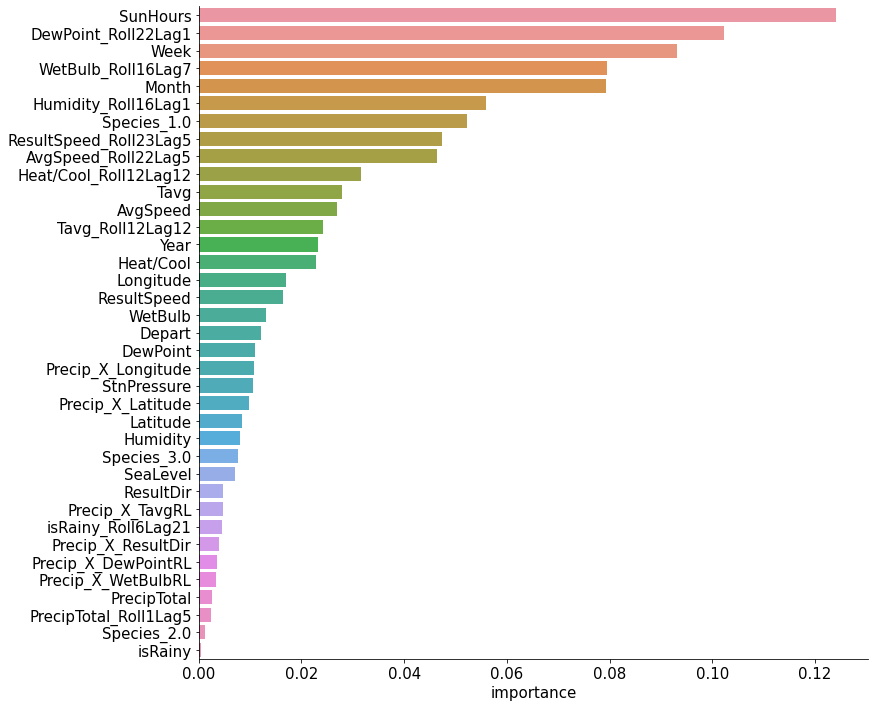

In [81]:
rf_ftimp = best_rf.feature_importances_

rf_ft = pd.DataFrame(rf_ftimp, columns=['importance'],index=X_train_sc.columns).sort_values(by='importance',ascending=False)
fig, ax = plt.subplots(figsize=(12,12))
sns.barplot(data= rf_ft, y=rf_ft.index, x='importance', ax=ax)

Our most important feature is `SunHours`, which refers to the total amount of daylight in a given day. Culex mosquitos are known to be [more active at night](https://www.terminix.com/blog/science-nature/when-are-mosquitoes-active/), hence perhaps longer periods of night allow them more time to spread the virus. Week and Month also appear as important features, and this is no surprise, since we already saw in our EDA that WNV prevalence tends to peak around July and August. 

A vindicating observation here is that our rolled and lagged features all have quite high importance, with the exception of the lagged isRainy feature. These features were engineered in a way that sought to correlate weather conditions during the previous mosquito generation with the prevalence of WNV in the current generation. Our findings suggest that this is indeed the case, that weather features lagged and rolled in time have a higher predictive effect on WNV prevalence as compared to weather features now, as weather conditions in the previous generation directly affect the breeding conditions that give rise to the current generation. For instance, an easy feature to understand is `Humidity`. We know that humid conditions are ideal for mosquito activity. What our engineered humidity then tells us is that taking into account the moving average of the past 16 days' humidity, combined with a further lag of 1 day, can help to predict the prevalence of WNV today. This is because the more humid the previous 16 days were, the more likely that the previous generation of mosquitos were active and thus laid more eggs. We can surmise that these conditions were more relevant to the previous generation because mosquitos can go from [egg to adult in 7-10 days](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html). Another feature to look at is `ResultSpeed` and `AvgSpeed`. The reason why looking at the lagged version of these features makes sense is because in fact, wind speed plays a big part in [whether mosquitos are able to find food](https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-6-129) (i.e. us humans). When wind is strong, it blows away the C02 that we humans emit constantly. Mosquitos find us by tracking our C02 emissions, and thus when wind is high in the previous generation, mosquitos can't find food, their survival rate goes down, and there are overall less mosquitos to lay the eggs that gives rise to the next generation.

This is not to say, however, that current weather features are not important. We are only able to measure WNV prevalence if we catch mosquitos in the first place, and thus weather features that directly affect current mosquito activity will also affect mosquito capture rates, which affects our ability to measure WNV prevalence. The 2 most important non-lagged, non-rolled features are `Tavg` and `AvgSpeed`. We already know that [mosquito activity increases with temperature](https://www.orkin.com/other/mosquitoes/activity), with mosquitos prefering to be active during warmer periods. Based on information from our own National Environment Agency, we also know that mosquito traps work by [mimicking human C02 emissions](https://www.nea.gov.sg/corporate-functions/resources/research/mosquito-traps/effectiveness-of-mosquito-traps), which is what mosquitos are attracted to. During days of high average wind speed, it stands to reason then that these traps are less effective in trapping mosquitos, as the C02 released by them gets quickly blown away by the wind, thus less mosquitos get trapped.

Disappointingly, the few interaction terms that we engineered using `PrecipTotal` do not seem to be that important. However, they are almost all at least somewhat more important than the base `PrecipTotal` feature, indicating that precipitation as a feature on its own doesn't tell us much, and that we must consider mediating effects by other features. For example, `PrecipTotal`, when interacted with both `Latitude` and `Longitude`, gives rises to more predictive features. This could be that in certain locales that have many catchbasins where stagnant water could collect, precipitation gives rise to more mosquitos and hence more WNV prevalence. Hence precipitation is an important factor only if it directly leads to stagnant water pooling in areas with poor ventilation or drainage. For example, in a well-maintained downtown area with constant cleaning and good drainage, we would not expect precipitation to lead to much stagnant water collecting, regardles of how much rain there is. Our RandomForestClassifier is able to learn these hotspots because it is able to model non-linearities in our data. This provides us with a better way to use what is otherwise a very weak feature on its own.

Let's also take a look at the predicted probabilities for each class.

In [12]:
# extracts the predicted probabilities for each class, for each given observation
predictions = best_rf.predict(X_val_sc)
class_0, class_1 = list(zip(*best_rf.predict_proba(X_val_sc)))
preds_df = pd.DataFrame({'actually_WNV': y_val,
              'predicted_WNV': predictions,
              'p_no_WNV': class_0,
              'p_WNV': class_1})

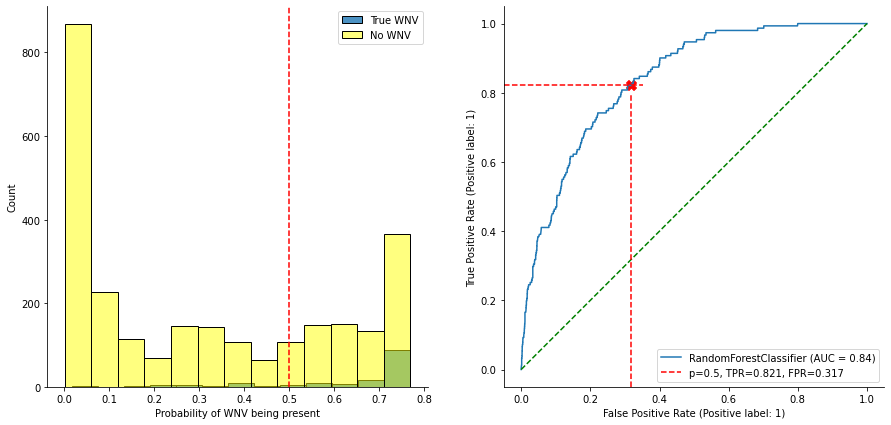

In [13]:
# plot histogram for the class probabilities for true r/options posts
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
sns.histplot(data=preds_df[preds_df['actually_WNV']==1], x='p_WNV', alpha=0.8, label ='True WNV', ax=ax1)
# plot histogram for the class probabilities for true r/stocks posts
sns.histplot(data=preds_df[preds_df['actually_WNV']==0], x='p_WNV', alpha=0.5, color='yellow', label='No WNV', ax=ax1)
ax1.axvline(0.5, linestyle='dashed', c='red')
ax1.set_xlabel('Probability of WNV being present')
ax1.legend()

# plot roc curve
plot_roc_curve(best_rf, X_val_sc, y_val, ax=ax2)
ax2.plot([0,1],[0,1], linestyle='dashed', c='green')

# create a confusion matrix that allows us to calculate point where our threshold intersects the curve
tn, fp, fn, tp = confusion_matrix(y_val, predictions).ravel()
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)
ax2.scatter(fpr, tpr, marker='X', c='red', s=100)
ax2.axvline(fpr, ymax=tpr-0.05, linestyle='dashed', c='red', label='p=0.5, TPR={:.3f}, FPR={:.3f}'.format(tpr, fpr))
ax2.axhline(tpr, xmax=fpr+0.05, linestyle='dashed', c='red')
ax2.legend();

Here we see that due to our high class imbalance, it was quite hard for our classifier to accurately predict WnvPresent. While a majority of True Negatives were highly predicted to be negative, i.e. p < 0.1, we also see that there are still quite a few negative observations which our model thought were fairly likely (p > 0.7) to belong to the positive class. This relatively high number of False Positives is a consequence of us choosing to prioritise public health. 

We also see that for our positive class, our model did not go over p=0.8 for any of the True Positives, indicating that our model is still fairly uncertain about these observations. This tells us that we need more conclusive data about our positive class, so that our model can more precisely learn how to classify True Positives, and produce higher predicted probabilities for our positive class. 

The ROC plot visualizes for us this tradeoff between False Negatives and False Positives. Based on this curve, we could opt to choose a different threshold based on our own requirements. If we still want to further reduce False Negatives in lieu of public health concerns, we can do so at the expense of even more False Positives. Conversely, we could increase our threshold if we decide that a small increase in our number of False Negatives is worth a larger decrease in False Positives.

## Cost Benefit Analysis 

Going back to our problem statement, we want to be able to quantify the effect of West Nile Virus on Chicago in terms of both health and monetary costs. Let's look first at the current cost of mosquito spraying efforts to gauge what our expenditure is currently like.

Chicago uses a type of pesticide called [Zenivex](https://www.chicago.gov/content/dam/city/depts/cdph/statistics_and_reports/CDInfo_2013_JULY_WNV.pdf). A [30 gallon container](https://www.forestrydistributing.com/aqua-zenivex-e20-ulv-insecticide-zeocon) of this costs \\$10800. For a city like Chicago, they would employ the use of trucks to spray Zenivex through the streets.  From the [Central Mass. Mosquito Control Project](https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox), we found out that these pesticide spraying trucks can spray betwwen 4.5-9 ounces of pesticide per minute, and travel about 10-15 mph. We can then estimate that 1 single 30-gallon container of pesticide will provide around **12-14 hours of spraying**. There are approximately 4000 miles of street in Chicago to spray, if we aim to cover all of Chicago. Given the speed of trucks and the amount of street to cover in Chicago, we estimate that these trucks can take anywhere between **260-300 manhours** to spray the entire of Chicago. Thus we will need about 25 30-gallon containers, about \\$250k worth, to spray Chicago once. Accounting for manpower costs at a minimum wage of around \\$15 per hour, it will cost Chicago an additional $4-5k. All in, the cost of spraying per instance is **\\$255,000**. Let's assume that for optimal benefit, we spray over a period of 8 weeks, starting from before the typical peak onset of WNV in July. It will cost Chicago **\\$2 mil** a year to spray the *entirety* of Chicago indiscriminately.

Let's now examine both the hidden and not-so-hidden costs of a person getting infected with WNV. A person getting infected by WNV has about a 1 in 5 chance of developing West Nile Fever, and a 1 in 150 chance of developing a more serious disease called West Nile Neurodegenerative Disease as per the [CDC](https://www.cdc.gov/westnile/index.html). A paper by [R. Peterson](https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article) has already done this analysis for us, so let's look at his findings. According the Peterson, the average cost for a person who develops West Nile Fever is about **\\$1000** in healthcare and lost productivity costs. The average cost for a person who develops the more severe WNND is **\\$72,000** in comparison. More recently, a research scholar named Christopher Conover published an article discussing the [cost of a life lost to COVID.](https://www.forbes.com/sites/theapothecary/2020/03/27/how-economists-calculate-the-costs-and-benefits-of-covid-19-lockdowns/?sh=383546da6f63) This graphic summarizes his findings.
<img src="../images/cost_of_life.png" alt="Drawing" style="width: 500px;"/>

While this was done in the context of COVID, we can likewise extrapolate similar 'costs' of a person's death. Conover himself opts to use what he calls the Quality Adjusted Life Year as a metric to measure the value of a person's life, which basically takes into account the quality of life. Using his metric, he estimates the value of a person's life to be about **\\$3 million** for someone aged 45-59 yrs.

[In Chicago in 2017](https://chicago.cbslocal.com/2018/08/29/west-nile-virus-death-reported-in-illinois/), 90 people contracted WNV, with 8 fatalities. Going by Peterson's metric, Chicago already lost \\$24 million purely due to deaths, **12 years** worth of spraying. This does not incorporate the human cost on family and friends who have to bear this loss. Based on our current running cost of $440,000 a year to spray the *entirety* of Chicago for 8 weeks straight, we already see that if Chicago was able to prevent 1 fatality, it would have compensated for **1.5** years worth of spraying, or it could have sprayed for 12 weeks a year instead and still the costs saved by preventing deaths would pay for the entire year's spraying. 

Looking at this, it is clear why we prioritised reducing False Negatives in our model at the expense of False Positives. Currently, Chicago does not yet spray the entire city, only areas that it considers high-risk. Thus their current cost is not even near our projected $2 mil per year for spraying the entire city. Whatever cost savings they could gain by choosing to selectively spray certain areas is certainly not worth the risk of someone dying to WNV.

Below is a heuristic that Chicago can use contextualize the cost of spraying:

|# of types of cases prevented|Cost savings to city|
|---|---|
|30 people prevented from getting WNND| 1 full year of spraying the entire city|
|1 person prevented from dying due to WNV| 1.5  years of spraying the entire city|

Even though our model prioritises recall ahead of false positives, we actually only have a False Positive Rate of 32\%. This means that even if the Chicago chooses to spray all the areas that our model predicts to be positive for WNV, it still will only spray less than half the city, which brings down the cost from our projected estimates earlier. Thus it is clear that the city of Chicago should not find cost to be an issue when deciding whether or not to spray.

## Conclusion

In conclusion, we found that there are two classes of features that help to predict the prevalence of WNV. The first and obvious one are weather features today that directly affect mosquito activity, and thus mosquito capture rates. Higher temperature days promote mosquito activity, which allows us to catch more of them, while higher wind speeds have the opposite effect of making mosquito traps less effective. The second class of features are weather features lagged and rolled in time to capture the weather conditions present during the previous generation of mosquitos. These conditions affect the activity and survival of the previous generation, which directly impacts their ability to breed and thus pass on WNV through the next generation. Importantly, our prescribed method of using the Cross Correlation Map can be easily used to discover these features further back in time.


## Recommendations

Below are some recommendations for CDC:

**Explore genetically modified mosquito for Culex breed**  
In the United States, the U.S. Environmental Protection Agency (EPA) has authorized use of OX5034 genetically modified Ae. aegypti mosquitoes for release in counties in Florida and Texas. We propose to expand the research to explore other breeds, including for the Culex breed. This technique has proven to be successful in Singapore. Genetically modified mosquitoes carry self-limiting genes that prevents mosquito offsprings from surviving to adulthood, hence reducing the target breed of mosquito.
  
**More active on-the-ground monitoring**  
Especially more so during the summer months of July and August, there should be more active ground work to monitor potential breeding areas. Using Singapore as an example, clear guidelines are set to specific areas (e.g. construction sites, schools, residential areas) as to where checks should be done and how frequent it should be done. 

**Education**  
As much as practical means can be done, most of the responsibility still boil down to individuals to prevent breeding of mosquito. Again using Singapore as an example, there are several means of educating people in terms of mosquito prevention that perhaps Chicago can emulate from. Ranging from short snippets through social media or television broadcast on mosquito prevent techniques to posters being put up in common residential areas, these are all small but powerful and cheap ways to nudge people to take ownership of the situation.

To have better prediction power for our model, we also recommend analysing trap data in conjunction with weather data even further back than we were able to. We were limited to a combined lag and roll buffer of 28 days due to data constraints. However, it is possible that due to the exponential breeding abilities of mosquitos, being able to analyze weather conditions 2 or more generations back from the current one could be even more useful in predicting, and hence preventing WNV outbreaks.

## Kaggle submission

In [11]:
test = pd.read_csv('../predict_data/test.csv')
id_col = test['Id']
test.drop(columns=['Trap','Sunset','Sunrise','year-mth'], inplace=True)
test = test[X_train_sc.columns]

In [12]:
# scale our data
test_sc = custom_scaler(test, cat_cols, fit=False)

In [113]:
pred_probas = best_rf.predict_proba(test_sc)[:,1]

In [125]:
# create our data to submit
kaggle_preds = pd.DataFrame()
kaggle_preds['Id'] = id_col
kaggle_preds['WnvPresent'] = pred_probas

kaggle_preds

,Id,WnvPresent
0,1,0.015570
1,2,0.016118
2,3,0.022526
3,4,0.020930
4,5,0.020930
...,...,...
116288,116289,0.210686
116289,116290,0.210686
116290,116291,0.210686
116291,116292,0.210686


In [115]:
kaggle_preds.to_csv('./predict_data/kaggle_submission.csv', index=False)
# score: 0.68

In [126]:
xgb_pred_proba = xgb_smote_cv.best_estimator_['xgb'].predict_proba(test_sc)[:,1]
kaggle_xgb = pd.DataFrame()
kaggle_xgb['Id'] = id_col
kaggle_xgb['WnvPresent'] = xgb_pred_proba
kaggle_xgb.to_csv('./predict_data/kaggle_xgb.csv', index=False)
# xgboost score: 0.66

In [14]:
lr_probs = lr_cv.best_estimator_['lr'].predict_proba(test_sc)[:,1]
kaggle_lr = pd.DataFrame()
kaggle_lr['Id'] = id_col
kaggle_lr['WnvPresent'] = lr_probs
kaggle_lr.to_csv('./predict_data/kaggle_lr_nosmote.csv', index=False)

# logreg with no smote score: 0.74